In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/自習/SSD_medical

/content/drive/My Drive/自習/SSD_medical


In [ ]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import time
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import numpy as np
import argparse

In [ ]:
args = {'dataset':'BCCD',  # VOC → BCCD
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':12,
        'resume':'',
        'start_iter':0,
        'num_workers':0,  # 4 → 0
        'cuda':True,  # Macの場合False
        'lr':5e-4,
        'momentum':0.9,
        'weight_decay':5e-4,
        'gamma':0.1,
        'save_folder':'weights/'
}

In [ ]:
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [ ]:
if not os.path.exists(args['save_folder']):
    os.mkdir(args['save_folder'])

In [ ]:
cfg = voc
dataset = VOCDetection(root=VOC_ROOT,
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))
cfg

{'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
 'clip': True,
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'lr_steps': (8000, 10000, 12000),
 'max_iter': 3000,
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'min_dim': 300,
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'name': 'BCCD',
 'num_classes': 21,
 'steps': [8, 16, 32, 64, 100, 300],
 'variance': [0.1, 0.2]}

In [ ]:
ssd_net = build_ssd('train', cfg['min_dim'], 4)
net = ssd_net
print(net)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
if args['cuda']:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True

In [ ]:
if args['resume']:
    print('Resuming training, loading {}...'.format(args['resume']))
    ssd_net.load_weights(args['resume'])
else:
    vgg_weights = torch.load(args['save_folder'] + args['basenet'])
    print('Loading base network...')
    ssd_net.vgg.load_state_dict(vgg_weights)

Loading base network...


In [ ]:
if args['cuda']:
    net = net.cuda()

In [ ]:
def adjust_learning_rate(optimizer, gamma, step):
    lr = args['lr'] * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
 
def xavier(param):
    init.xavier_uniform(param)
 
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()
        

In [ ]:
if not args['resume']:
    print('Initializing weights...')
    # initialize newly added layers' weights with xavier method
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

Initializing weights...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys


In [ ]:
# 最適化パラメータの設定
optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'],
                      weight_decay=args['weight_decay'])

In [ ]:
# 損失関数の設定
criterion = MultiBoxLoss(4, 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

In [ ]:
net.train()
# loss counters
loc_loss = 0
conf_loss = 0
epoch = 0
print('Loading the dataset...')
 
epoch_size = len(dataset) // args['batch_size']
print('Training SSD on:', dataset.name)
print('Using the specified args:')
print(args)

Loading the dataset...
Training SSD on: VOC0712
Using the specified args:
{'dataset': 'BCCD', 'basenet': 'vgg16_reducedfc.pth', 'batch_size': 12, 'resume': '', 'start_iter': 0, 'num_workers': 0, 'cuda': True, 'lr': 0.0005, 'momentum': 0.9, 'weight_decay': 0.0005, 'gamma': 0.1, 'save_folder': 'weights/'}


In [ ]:
step_index = 0
 
# 訓練データの読み込み
data_loader = data.DataLoader(dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

In [ ]:
# 学習の開始
loss_list = []
batch_iterator = None
# iterationでループして、cfg['max_iter']まで学習する
for iteration in range(args['start_iter'], cfg['max_iter']):
    # 学習開始時または1epoch終了後にdata_loaderから訓練データをロードする
    if (not batch_iterator) or (iteration % epoch_size ==0):
      batch_iterator = iter(data_loader)
      loc_loss = 0
      conf_loss = 0
      epoch += 1
 
    if iteration in cfg['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, args['gamma'], step_index)
 
    # load train data
    # バッチサイズ分の訓練データをload
    images, targets = next(batch_iterator)
 
    if args['cuda']:
        images = Variable(images.cuda())
        targets = [Variable(ann.cuda(), volatile=True) for ann in targets]
    else:
        images = Variable(images)
        targets = [Variable(ann, volatile=True) for ann in targets]
    # forward
    t0 = time.time()
    out = net(images)
    # backprop
    optimizer.zero_grad()
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    loss.backward()
    optimizer.step()
    t1 = time.time()
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
 
    #ログの出力
    if iteration % 10 == 0:
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')
    loss_list.append(np.array(loss.item()))
 
# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 5.2625 sec.
iter 0 || Loss: 18.2838 || timer: 0.1213 sec.
iter 10 || Loss: 9.6155 || timer: 0.1191 sec.
iter 20 || Loss: 9.0235 || timer: 0.1169 sec.
iter 30 || Loss: 7.5488 || timer: 0.1180 sec.
iter 40 || Loss: 7.2743 || timer: 0.1199 sec.
iter 50 || Loss: 6.5788 || timer: 0.1193 sec.
iter 60 || Loss: 5.7674 || timer: 0.1303 sec.
iter 70 || Loss: inf || timer: 0.1182 sec.
iter 80 || Loss: 5.5223 || timer: 0.1155 sec.
iter 90 || Loss: 5.5438 || timer: 0.1188 sec.
iter 100 || Loss: 5.3421 || timer: 0.1308 sec.
iter 110 || Loss: 5.0469 || timer: 0.1321 sec.
iter 120 || Loss: 4.6701 || timer: 0.1183 sec.
iter 130 || Loss: 4.8670 || timer: 0.1207 sec.
iter 140 || Loss: 5.3148 || timer: 0.1156 sec.
iter 150 || Loss: 5.0996 || timer: 0.1298 sec.
iter 160 || Loss: 5.0849 || timer: 0.1161 sec.
iter 170 || Loss: 4.7148 || timer: 0.1303 sec.
iter 180 || Loss: 4.6234 || timer: 0.1190 sec.
iter 190 || Loss: 4.7446 || timer: 0.1244 sec.
iter 200 || Loss: 4.6725 || timer: 0.1338 sec.
iter 21

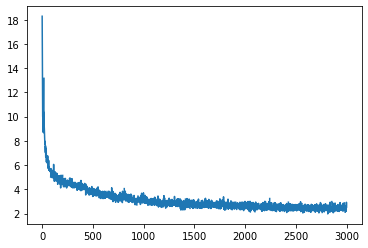

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(loss_list)
plt.show()

In [ ]:
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')